In [3]:
# import module

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
import pandas as pd

<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_17244\3992229639.py:24: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('mass [$M_\odot$]')


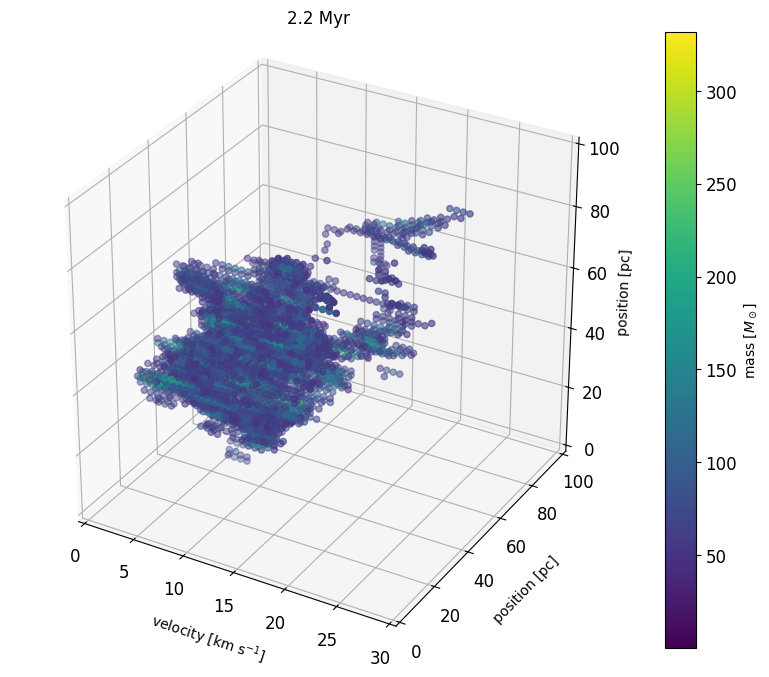

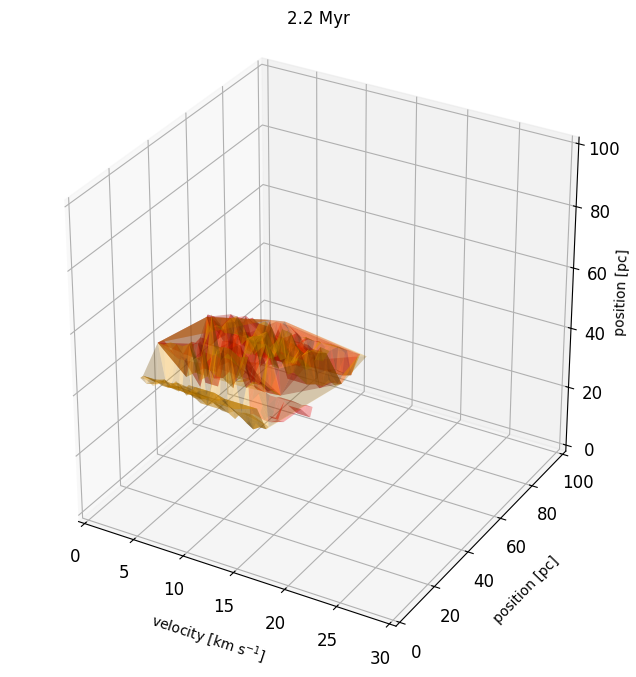

In [4]:
data = np.load("datasets/mass_ppv/2800.npz")
rv = data['arr_0']
pc = data['arr_1']
m = data["arr_2"]
shape = m.shape
gas_mass = m.reshape(-1)
colormap = plt.get_cmap('viridis')
norm = plt.Normalize(gas_mass.min(), gas_mass.max())
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))
x_coords = np.repeat(np.arange(shape[0]), shape[1]*shape[2]) * rv
y_coords = np.tile(np.repeat(np.arange(shape[1]), shape[2]), shape[0]) * pc
z_coords = np.tile(np.arange(shape[2]), shape[0]*shape[1]) * pc
threshold = 50
mask= gas_mass > threshold
x_filtered = x_coords[mask]
y_filtered = y_coords[mask]
z_filtered = z_coords[mask]
gas_mass_filtered = gas_mass[mask]
scatter = ax.scatter(x_filtered, y_filtered, z_filtered, 
                     c=gas_mass_filtered, cmap=colormap, norm=norm) 
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('mass [$M_\odot$]')
cbar.ax.tick_params(labelsize=12) 
ax.set_xlim3d(0, 30)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)
plt.title("2.2 Myr")
X = ax.set_xlabel('velocity [km s$^{-1}$]', labelpad=10)
Y = ax.set_ylabel('position [pc]', labelpad=10)
Z = ax.set_zlabel('position [pc]', labelpad=4)
plt.tick_params(labelsize=12)

min_value = 90
min_delta = 20
min_npix = 50
dendro3D_400 = Dendrogram.compute(m, min_value=min_value, min_delta=min_delta, min_npix=min_npix)
leaf_indices = [i for i, structure in enumerate(dendro3D_400.all_structures) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro3D_400.all_structures) if structure.is_branch]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))
for i, structure_index in enumerate(leaf_indices):
    structure = dendro3D_400[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * rv, indices[1] * pc, indices[2] * pc, color='red', alpha=0.3)
for j, structure_index in enumerate(branch_indices):
    structure = dendro3D_400[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * rv, indices[1] * pc, indices[2] * pc, color='orange', alpha=0.3)
ax.set_xlim3d(0, 30)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)
plt.title("2.2 Myr")
X = ax.set_xlabel('velocity [km s$^{-1}$]', labelpad=10)
Y = ax.set_ylabel('position [pc]', labelpad=10)
Z = ax.set_zlabel('position [pc]', labelpad=3)
plt.tick_params(labelsize=12)

size, radius, mass, v_dispersion, vir_param = [], [], [], [], []
for index in leaf_indices:
    s = dendro3D_400[index]
    npix = s.get_npix()
    size.append(round(npix * rv * pc**2, 0))
    radius.append(round(np.cbrt(3 * (npix * rv * pc**2) / (4 * np.pi)), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    mass.append(np.sum(m[indices]))
    rv_indices = indices[0] * rv
    v_dispersion.append(np.var(rv_indices))
    vir_param.append(round(1.2e3 * 
                    np.cbrt(3 * (npix * rv * pc**2) / (4 * np.pi)) * 
                    np.var(rv_indices)**2 /
                    (3 * np.sum(m[indices])), 6))
results_leaves = pd.DataFrame({'size': size, 
                               'radius': radius, 
                               'mass': mass, 
                               'velocity dispersion': v_dispersion, 
                               'virial parameter': vir_param})
size, radius, mass, v_dispersion, vir_param = [], [], [], [], []
for index in branch_indices:
    s = dendro3D_400[index]
    npix = s.get_npix()
    size.append(round(npix * rv * pc**2, 0))
    radius.append(round(np.cbrt(3 * (npix * rv * pc**2) / (4 * np.pi)), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    mass.append(np.sum(m[indices]))
    rv_indices = indices[0] * rv
    v_dispersion.append(np.var(rv_indices))
    vir_param.append(round(1.2e3 * 
                    np.cbrt(3 * (npix * rv * pc**2) / (4 * np.pi)) * 
                    np.var(rv_indices)**2 /
                    (3 * np.sum(m[indices])), 6))
results_branches = pd.DataFrame({'size': size, 
                               'radius': radius, 
                               'mass': mass, 
                               'velocity dispersion': v_dispersion, 
                               'virial parameter': vir_param})
results_leaves.to_csv("results_leaves_2800_3D.csv")
results_branches.to_csv("results_branches_2800_3D.csv")